# ***Light GBM Boosting***

İkinci proje olan regresyon projesinde ve üçüncü proje olan sınıflandırma projesinde kullandığınız veri kümelerini tekrar kullanarak, ***Light GBM*** ile regresyon ve sınıflandırma modelleri oluşturun ve bu modeller için en uygun parametre değerlerini belirleyin. En ideal parametreyi bulmak için daha önceki bölümde öğrendiğiniz çapraz doğrulama metotlarını kullanabilirsiniz.

---

## ***Classification - Titanic***

- Siniflandirma projesinde Titanic verileriyle calismistik, burada da ayni veri setiyle calisacagiz.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# light gbm model
import lightgbm as lgb
# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# cross validation
from sklearn.model_selection import cross_validate
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# hiperparametre tuning icin
from sklearn.model_selection import GridSearchCV

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}

### ***Veri Kesfi***
- Veri setini inceleme.

In [37]:
# veri setini dataframe icerisine yukle
titanic = pd.read_csv('data/titanic_train.csv')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Cabin, Ticket degiskenleri numerik olmadigindan ve burada ihtiyacimiz olmadigindan cikarabiliriz.

In [38]:
titanic = titanic.drop(['Cabin','Ticket'], axis=1)
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked'],
      dtype='object')

In [39]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

- Embarked 3 farkli deger almis, eksik veriler en sik karsilasilan degerle doldurulabilir.

In [40]:
titanic['Embarked'].fillna('S', inplace=True)

- Son olarak yas degeri de ortalama deger ile dolduruldu.

In [41]:
titanic['Age'].fillna(np.floor(titanic['Age'].mean()), inplace=True)

In [42]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


***Cinsiyet ve Liman bilgisi encode edilerek dahil edildi***

In [43]:
# get_dummies metodu ile encode edilir
titanic = pd.concat([titanic, pd.get_dummies(titanic.Sex, 
                                             drop_first=True)], axis=1)
titanic = pd.concat([titanic, pd.get_dummies(titanic.Embarked, 
                                             drop_first=True, prefix='Embarked')], axis=1)
# encode edilen sutunlar drop edilir
titanic.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [44]:
def add_title(col):
    if 'Mrs' in col:
        return 'mrs'
    elif 'Master' in col:
        return 'master'
    elif 'Mr' in col:
        return 'mr'
    elif 'Miss' in col:
        return 'miss'
    else:
        return 'no_title'

In [45]:
titanic['title'] = titanic['Name'].apply(add_title)

In [46]:
titanic['title'].unique()

array(['mr', 'mrs', 'miss', 'master', 'no_title'], dtype=object)

In [47]:
titanic = pd.concat([titanic,pd.get_dummies(titanic['title'])], axis=1)

In [48]:
titanic

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S,title,master,miss,mr,mrs,no_title
0,1,0,3,"Braund, Mr. Owen Harris",22.000,1,0,7.250,1,0,1,mr,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.000,1,0,71.283,0,0,0,mrs,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.000,0,0,7.925,0,0,1,miss,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000,1,0,53.100,0,0,1,mrs,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.000,0,0,8.050,1,0,1,mr,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.000,0,0,13.000,1,0,1,no_title,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.000,0,0,30.000,0,0,1,miss,0,1,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",29.000,1,2,23.450,0,0,1,miss,0,1,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",26.000,0,0,30.000,1,0,0,mr,0,0,1,0,0


In [49]:
titanic.drop(['Name', 'title', 'no_title'], axis=1, inplace=True)

In [50]:
titanic

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S,master,miss,mr,mrs
0,1,0,3,22.000,1,0,7.250,1,0,1,0,0,1,0
1,2,1,1,38.000,1,0,71.283,0,0,0,0,0,0,1
2,3,1,3,26.000,0,0,7.925,0,0,1,0,1,0,0
3,4,1,1,35.000,1,0,53.100,0,0,1,0,0,0,1
4,5,0,3,35.000,0,0,8.050,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000,0,0,13.000,1,0,1,0,0,0,0
887,888,1,1,19.000,0,0,30.000,0,0,1,0,1,0,0
888,889,0,3,29.000,1,2,23.450,0,0,1,0,1,0,0
889,890,1,1,26.000,0,0,30.000,1,0,0,0,0,1,0


### ***Light GBM modeli***

In [51]:
# hedef ve aciklayici degiskenler
X = titanic.drop(['Survived', 'PassengerId'], axis=1)
y = titanic['Survived']

# egitim ve test kumesini ayir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)

- Eğitim verilerini modelde eğitmeden önce LightGBM veri formatına çevirmemiz gerekiyor.

In [52]:
# light gbm veri formatina donusturme
d_train = lgb.Dataset(X_train, label=y_train)

# modelde kullanilacak parametreler
params = {'boosting_type' : 'gbdt',
          'objective' : 'binary',
          'metric' : 'binary_logloss',
          'sub_feature' : 0.5,
          'num_leaves' :  10,
          'min_data' : 50,
          'max_depth' : 10}

# model egitimi
lgb_model = lgb.train(params, d_train, num_boost_round = 100)

- Parametreler hakkinda bilgi icin [dokumantsayon](https://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters)
- Train metodu hakkinda bilgi icin [dokumantasayon](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train)

In [53]:
y_pred=lgb_model.predict(X_test)
y_pred[:10]

array([0.45215734, 0.95742179, 0.97896912, 0.15933999, 0.18771956,
       0.06514021, 0.21929915, 0.92980806, 0.06279279, 0.93803528])

- ```predict``` fonksiyonu önceki makine öğrenme algoritmalarından farklı olarak tahmin değeri yerine tahmin ihtimalini vermektedir. Yani ```predict_proba``` ile aldığımız sonucu döndürmektedir. 
- Bir eşik seviyesi beirleyerek, bu değerleri tahminlere çevirelim.

In [55]:
y_pred = [0 if pred < 0.5 else 1 for pred in y_pred]
y_pred[:10]

[0, 1, 1, 0, 0, 0, 0, 1, 0, 1]

In [56]:
# modelin performans metrikleri
print('accuracy score :{:.2f}'.format(accuracy_score(y_test, y_pred)))
print('f1 score       :{:.2f}'.format(f1_score(y_test, y_pred)))
print('roc auc score  :{:.2f}'.format(roc_auc_score(y_test, y_pred)))

accuracy score :0.83
f1 score       :0.77
roc auc score  :0.82


### ***Cross Validation - scikit-learn cross_validation metodu ile***
- Cross validation scikit-learn kutuphanesinin bir metodu oldugundan bu yontemi kullanmak icin scikit-learn API icin olusturulmus ```LGBMClassifier``` ile model olusturmaliyiz.

- Scikit-learn API [dokumantasyon](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

#### ***scikitlearn API LGBMClassifier model***

In [58]:
# aciklayici degiskenler ve hedef degisken tanimlamasi
X = titanic.drop(['Survived', 'PassengerId'], axis=1)
y = titanic['Survived']

# veri kumesini egitim ve test kumesi olarak ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)
# light gbm lineer siniflandirma modeli; 
# kucuk dataset icin overfitting den kacinmak icin max_depth=6 olarak belirledik
lgb_reg = lgb.LGBMClassifier(max_depth=6, n_jobs=4)

# modelimizi train verileri ile fit ettikten sonra 
# test verileri skoruna bakabiliriz
lgb_reg.fit(X_train, y_train)
print('accuracy : \n{:.2f}'.format(lgb_reg.score(X_test, y_test)))

accuracy : 
0.82


#### ***cross_validate***

In [60]:
# model nesnesi tekrar olusturulur, cross validate modeli kendi icinde egitir
lgb_cl = lgb.LGBMClassifier(max_depth=6, n_jobs=4)
cv = cross_validate(estimator=lgb_cl, X=X, y=y,
                    cv=10, scoring = ['roc_auc', 'f1'])

print('auc scores mean : \n{:.2f}\n'.format(cv['test_roc_auc'].mean()))
print('f1 scores mean  : \n{:.2f}\n'.format(cv['test_f1'].mean()))

auc scores mean : 
0.86

f1 scores mean  : 
0.77



### ***Cross Validation - lightgbm.cv metodu ile***

- Çapraz doğrulama için LightGBM'in içerisinde yer alan ```cv``` fonksiyonunu da kullanabiliriz.
- Veriyi öncesinde Light GBM veri yapısına çeviriyoruz.
- cv metodu hakkinda bilgi icin [dokumantasayon](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html)

In [61]:
# light gbm veri yapisina donusturme
d_train = lgb.Dataset(X, label=y)

# model parametreleri, 
# max_depth varsayilan -1 yani no_limit, ancak kucuk datasetlerde overfittinge yol acar 
# max_depth harici diger parametreler varsayilan degerler belirlenmis 
# yani burada yer almasa da model otomatik parametreleri bu sekilde belirleyecektir
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, 
    'n_estimators' : 100}

- ```early_stopping_rounds``` parametresi ile eger belirledigimiz round sayisi sonrasi metrikte(burada rmse degeri) bir degisiklik olmazsa boost round larini durdurur ve gelismenin olmadigi sonuclari kaydetmez o yuzden gelisme olmayan roundlar sanki hic yasanmamis gibi goruruz
- Sonuclar xgboost.cv de pandas df olarak kaydedilebiliyordu burada yalnizca dict olarak kaydediliyor.
- Metod ```early_stopping_rounds``` parametresi olmadan calistirildiginda 70-75 arasi boost roundlarda rmse metriginde bir gelisme olmadigi gorulecektir.

In [62]:
# early stopping rounds parametresi ile eger belirledigimiz round sayisi sonrasi 
# metrikte(burada rmse degeri) bir degisiklik olmazsa boost round larini durdurur ve gelismenin olmadigi
# sonuclari kaydetmez o yuzden gelisme olmayan roundlar sanki hic yasanmamis gibi goruruz
lgb_cv = lgb.cv(train_set=d_train, params=params, nfold=10,
                num_boost_round=100, early_stopping_rounds=5, metrics="auc", seed=123)

In [65]:
print('auc score          : ', end='')
print('{:.2f}'.format(np.max(lgb_cv['auc-mean'])))
print('boost round sayisi : ', end='')
print(len(lgb_cv['auc-mean']))

auc score          : 0.87
boost round sayisi : 37


### ***Hiperparametre Ayarlama - Grid Search ile***

In [71]:
# aciklayici degiskenler ve hedef degisken tanimlamasi
X = titanic.drop(['Survived', 'PassengerId'], axis=1)
y = titanic['Survived']
# veri kumesini egitim ve test kumesi olarak ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)

In [72]:
# modeli nesnesi tekrar olusturulur, grid search modeli kendi icinde egitir
lgb_cl = lgb.LGBMClassifier()
# model hangi parametreleri aliyor incele
print(lgb_cl.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [73]:
%%time
# hucre calisma suresi
parameters = {'reg_alpha': np.logspace(-3,3,7), 
              'reg_lambda': np.logspace(-3,3,7),
              'max_depth': np.arange(2,10)
             }
grid_cv_cl = GridSearchCV(estimator=lgb_cl, param_grid = parameters, 
                          cv = 10, scoring='roc_auc', n_jobs=6)

grid_cv_cl.fit(X_train, y_train)


# en iyi degerler
print('\nCross-Validate  Sonuclari\n')
print("En iyi parametreler : \n{}\n".format(grid_cv_cl.best_params_))
print("En iyi cv auc skor  : \n{:.2f}\n".format(grid_cv_cl.best_score_))


Cross-Validate  Sonuclari

En iyi parametreler : 
{'max_depth': 5, 'reg_alpha': 0.01, 'reg_lambda': 10.0}

En iyi cv auc skor  : 
0.88

CPU times: user 6.74 s, sys: 152 ms, total: 6.89 s
Wall time: 29.3 s


In [74]:
# test skorlari
print('\nTest Sonuclari\n')
print("Accuracy : \n{:.2f}\n".format(grid_cv_cl.score(X_test, y_test)))
# diger skorlar icin tahmin yap
y_pred = grid_cv_cl.predict(X_test)
# auc skoru icin tahmin olasiliklari gerekiyor
# survived 1 degerleri icin olasilik degerlerini al, 1 inci sutun degerleri
y_pred_prob = grid_cv_cl.predict_proba(X_test)[:,1]
print("AUC : \n{:.2f}\n".format(roc_auc_score(y_test,y_pred_prob)))
print("F1 : \n{:.2f}\n".format(f1_score(y_test,y_pred)))


Test Sonuclari

Accuracy : 
0.85

AUC : 
0.85

F1 : 
0.77



---

## ***Regression - House Prices***

- Regresyon projesinde House Prices verileriyle calismistik, burada da ayni veri setiyle calisacagiz.
- Temizlenmis ve aykiri degerlerden arindirilmis veri setiyle model olusturacagiz.

In [75]:
# temiz veri setini dataframe icerisine yukle
house_prices = pd.read_csv('data/house_prices_out.csv', index_col='Id')

In [76]:
house_prices

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,"2,003.000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.000,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,"1,999.000",RFn,2,460,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal,175000
1457,20,RL,85.000,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.000,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,"1,978.000",Unf,2,500,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1458,70,RL,66.000,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.000,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,"1,941.000",RFn,1,252,TA,TA,Y,0,60,0,0,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500


- Numerik olmayan degiskenler de encode edilerek numerik hale getirilir.

In [77]:
# kategorik degiskenleri encode eden fonksiyon
def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    # degerler index yapildi
    ordering.index = ordering.val
    # degisken degerlerinin SalePrice ortalamalarini aliyor
    ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    # ortalamalari siraliyor
    ordering = ordering.sort_values('spmean')
    # siralama degerleri ayri bir sutunda
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()    
    # en son soyle bir sozluk olusur ExterQual icin
    # {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    
    # burasi cok ilginc yeni encoded degiskeni burada olusturuyor
    for cat, o in ordering.items():        
        df.loc[df[feature] == cat, feature+'_E'] = o

In [78]:
# object tipinde olanlari ayir
qualitative = [column for column in house_prices.columns if house_prices.dtypes[column] == 'object']

# object tipinde olmayanlari ayir
quantitative = [column for column in house_prices.columns if house_prices.dtypes[column] != 'object']

qual_encoded = []
for q in qualitative:  
    encode(house_prices, q)
    qual_encoded.append(q+'_E')

quantitative.remove('SalePrice')
expl_vars = []
expl_vars = quantitative + qual_encoded

print('Min satis fiyati : {}\nMax satis fiyati : {}'.format(house_prices['SalePrice'].min(),
                                                            house_prices['SalePrice'].max()))

print('Aciklayici degisken adedi : {}'.format(len(expl_vars)))

Min satis fiyati : 34900
Max satis fiyati : 485000
Aciklayici degisken adedi : 79


### ***Light GBM modeli***

In [79]:
# hedef ve aciklayici degiskenler
X = house_prices[expl_vars]
y = house_prices['SalePrice']
# egitim ve test veri kumesini ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)

- Veriyi eğitmeden önce Light GBM veri yapısına çeviriyoruz.

In [80]:
# light gbm veri yapisina donusturme
d_train = lgb.Dataset(X_train, label=y_train)

- Parametreler hakkinda bilgi icin [dokumantsayon](https://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters)
- Train metodu hakkinda bilgi icin [dokumantasayon](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train)

In [81]:
# model parametreleri, 
# max_depth varsayilan -1 yani no_limit, ancak kucuk datasetlerde overfittinge yol acar 
# max_depth harici diger parametreler varsayilan degerler belirlenmis 
# yani burada yer almasa da model parametreleri otomatik bu sekilde belirleyecektir
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, 
    'n_estimators' : 100}

# model egitimi, num_boost_round varsayilan olarak 100 dur
lgb_reg = lgb.train(params, d_train, num_boost_round = 100)

### ***RMSE Score***

In [83]:
# model tahmini
y_pred = lgb_reg.predict(X_test)
y_pred_train = lgb_reg.predict(X_train)

# rmse hesaplama
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Light GBM RMSE: %f" % (rmse))

Light GBM RMSE: 18042.855092


- Tahmin degerlerini gercek degerlerle karsilastirma grafigini inceleyebiliriz.

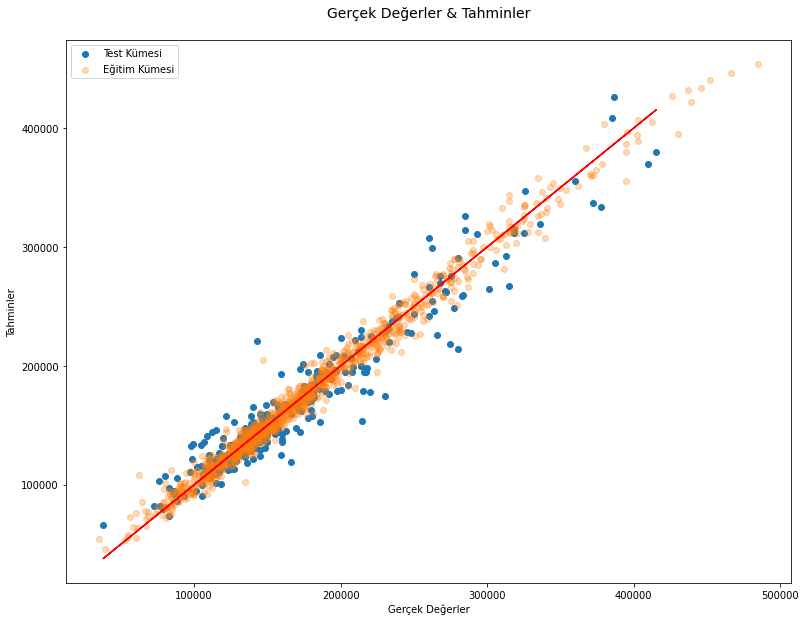

In [87]:
# tahmin degerlerini gercek degerlerle karsilastirma grafigi
plt.figure(figsize=(13,10))
plt.title('Gerçek Değerler & Tahminler\n', size = 14)
ax1 = plt.scatter(y_test, y_pred)
ax2 = plt.scatter(y_train, y_pred_train,alpha=0.30)
ax3 = plt.plot(y_test, y_test, color="red")
plt.legend((ax1, ax2), ('Test Kümesi', 'Eğitim Kümesi'))
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahminler")
plt.show()

### ***Cross Validation - scikit-learn cross_validation metodu ile***
- Cross validation scikit-learn kutuphanesinin bir metodu oldugundan bu yontemi kullanmak icin scikit-learn API icin olusturulmus ```LGBMRegressor``` ile model olusturmaliyiz.

- Scikit-learn API [dokumantasyon](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)

#### ***scikitlearn API LGBMRegressor model***

In [88]:
# aciklayici degiskenler ve hedef degisken tanimlamasi
X = house_prices[expl_vars]
y = house_prices['SalePrice']

# veri kumesini egitim ve test kumesi olarak ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)
# light gbm lineer regresyon modeli; 
# kucuk dataset icin overfitting den kacinmak icin max_depth=6 olarak belirledik
lgb_reg = lgb.LGBMRegressor(max_depth=6, n_jobs=4)

# modelimizi train verileri ile fit ettikten sonra 
# test verileri skoruna bakabiliriz
lgb_reg.fit(X_train, y_train)
print('Train R2 skor: \n{:.2f}\n'.format(lgb_reg.score(X_test, y_test)))

Train R2 skor: 
0.93



#### ***cross_validate***

In [92]:
# model nesnesi tekrar olusturulur, cross validate modeli kendi icinde egitir
lgb_reg = lgb.LGBMRegressor(max_depth=6, n_jobs=4)
cv = cross_validate(estimator=lgb_reg, X=X, y=y,
                    cv=10, scoring = ['neg_root_mean_squared_error', 'r2'])

print('rmse scores mean : \n{:.2f}\n'.format( 
      -cv['test_neg_root_mean_squared_error'].mean()))
print('r2 scores mean   : \n{:.2f}'.format( 
      cv['test_r2'].mean()))

rmse scores mean : 
19062.59

r2 scores mean   : 
0.92


### ***Cross Validation - lightgbm.cv metodu ile***

- Çapraz doğrulama için LightGBM'in içerisinde yer alan ```cv``` fonksiyonunu da kullanabiliriz.
- Veriyi öncesinde Light GBM veri yapısına çeviriyoruz.
- cv metodu hakkinda bilgi icin [dokumantasayon](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html)

In [93]:
# light gbm veri yapisina donusturme
d_train = lgb.Dataset(X, label=y)

# model parametreleri, 
# max_depth varsayilan -1 yani no_limit, ancak kucuk datasetlerde overfittinge yol acar 
# max_depth harici diger parametreler varsayilan degerler belirlenmis 
# yani burada yer almasa da model otomatik parametreleri bu sekilde belirleyecektir
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, 
    'n_estimators' : 100}

- ```early_stopping_rounds``` parametresi ile eger belirledigimiz round sayisi sonrasi metrikte(burada rmse degeri) bir degisiklik olmazsa boost round larini durdurur ve gelismenin olmadigi sonuclari kaydetmez o yuzden gelisme olmayan roundlar sanki hic yasanmamis gibi goruruz
- Sonuclar xgboost.cv de pandas df olarak kaydedilebiliyordu burada yalnizca dict olarak kaydediliyor.
- Metod ```early_stopping_rounds``` parametresi olmadan calistirildiginda 70-75 arasi boost roundlarda rmse metriginde bir gelisme olmadigi gorulecektir.

In [94]:
# early stopping rounds parametresi ile eger belirledigimiz round sayisi sonrasi 
# metrikte(burada rmse degeri) bir degisiklik olmazsa boost round larini durdurur ve gelismenin olmadigi
# sonuclari kaydetmez o yuzden gelisme olmayan roundlar sanki hic yasanmamis gibi goruruz
lgb_cv = lgb.cv(train_set=d_train, params=params, nfold=10, 
                num_boost_round=100, early_stopping_rounds=5, metrics="rmse", seed=123)

In [97]:
print('cv rmse score      : \n{:.2f}\n'.format(
    np.min(lgb_cv['rmse-mean'])))
print('boost round sayisi : \n{:.2f}\n'.format(len(lgb_cv['rmse-mean'])))

cv rmse score      : 
19318.81

boost round sayisi : 
70.00



### ***Hiperparametre Ayarlama - Grid Search ile***

In [100]:
# aciklayici degiskenler ve hedef degisken tanimlamasi
X = house_prices[expl_vars]
y = house_prices['SalePrice']

In [101]:
# modeli nesnesi tekrar olusturulur, grid search modeli kendi icinde egitir
lgb_reg = lgb.LGBMRegressor()
# model hangi parametreleri aliyor incele
print(lgb_reg.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [102]:
parameters = {'reg_alpha': np.logspace(-3,3,7), 
              'reg_lambda': np.logspace(-3,3,7),
              'max_depth': np.arange(2,10)
             }
grid_cv_reg = GridSearchCV(estimator=lgb_reg, param_grid = parameters, 
                       cv = 10, scoring='neg_root_mean_squared_error', n_jobs=6)
grid_cv_reg.fit(X, y)

print("En iyi parametreler : \n", grid_cv_reg.best_params_)
print("\nEn iyi rmse         : \n{:.2f}\n".format(-grid_cv_reg.best_score_))

En iyi parametreler : 
 {'max_depth': 3, 'reg_alpha': 10.0, 'reg_lambda': 1.0}

En iyi rmse         : 
18936.88



### ***Hiperparametre Ayarlama - lightgbm.cv ile***

In [103]:
# aciklayici degiskenler ve hedef degisken tanimlamasi
X = house_prices[expl_vars]
y = house_prices['SalePrice']
# lightgbm veri yapisina donusturme
d_train = lgb.Dataset(X, label=y)
# parametre range belirleme
l1_params = np.logspace(-3,3,7)
l2_params = np.logspace(-3,3,7)
max_depth_params = np.arange(2,10)
# temel parametreler
# parametreler varsayilan degerler olarak belirlenmis 
# yani burada yer almasa da model otomatik parametreleri bu sekilde belirleyecektir
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse', 
    'learning_rate': 0.1,
    'verbose': 0, 
    'n_estimators' : 100}
# en iyi rmse ve hiperparametreleri tutacak degiskenler
best_rmse = 30000
best_l1, best_l2, best_max_depth = (0,0,0) 

for alpha in l1_params:
    params["alpha"] = alpha
    for lambd in l2_params:
        params["lambda"] = lambd
        for max_depth in max_depth_params:
            params["max_depth"] = max_depth
            cv_rmse = lgb.cv(train_set=d_train, params=params, nfold=10, num_boost_round=100, 
                             metrics="rmse", early_stopping_rounds=10, seed=123)
            iter_rmse = np.min(lgb_cv['rmse-mean'])
            if  iter_rmse < best_rmse:
                best_rmse = iter_rmse
                best_l1, best_l2, best_max_depth = alpha, lambd, max_depth


print('En iyi parametreler :')
print('l1          : ', best_l1)
print('l2          : ', best_l2)
print('max_depth   : ', best_max_depth)
print('En iyi rmse : ', best_rmse)

En iyi parametreler :
l1          :  0.001
l2          :  0.001
max_depth   :  2
En iyi rmse :  19318.81443008739


- ***???*** Grid Search daha iyi sonuc verdi, ayni sonuclari elde etmemiz bekleniyordu, ```cv``` metodundaki ```early_stopping_rounds``` parametresinden kaynaklaniyor olabilir. GridSearch de bu parametreyi girdi olarak veremiyoruz. Ancak estimator un fit metodu bu parametreyi aliyor bir de oyle denenebilir. [Stackoverflow](https://stackoverflow.com/questions/42993550/gridsearchcv-xgboost-early-stopping) incelenebilir.